In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import get_training_data

In [3]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Generate Random Points as Negatives

In [ ]:
import geopandas as gpd
from shapely.geometry import Point
import numpy as np
from shapely.strtree import STRtree

# Parameters
patch_size_m = 2560  # 256px at 10m resolution
grid_spacing = patch_size_m

# Load data
boundary = gpd.read_file("../data/boundaries/bolivar.geojson").to_crs(epsg=3857)
positive_points = gpd.read_file("../data/sampling_locations/v2.1_bolivar_cleaned_positives.geojson").to_crs(epsg=3857)

# Create grid of candidate points
minx, miny, maxx, maxy = boundary.total_bounds
x_coords = np.arange(minx, maxx, grid_spacing)
y_coords = np.arange(miny, maxy, grid_spacing)
grid_points = [Point(x, y) for x in x_coords for y in y_coords]
grid_gdf = gpd.GeoDataFrame(geometry=grid_points, crs=boundary.crs)

# Clip grid to boundary
grid_gdf = gpd.clip(grid_gdf, boundary)

# Buffer positive points to exclude nearby areas
positive_buffered = positive_points.buffer(patch_size_m)
positive_union = positive_buffered.unary_union  # shapely geometry

# Filter out grid points that intersect buffered positives
grid_gdf["is_valid"] = ~grid_gdf.geometry.intersects(positive_union)
valid_points = grid_gdf[grid_gdf["is_valid"]].drop(columns="is_valid").reset_index(drop=True)

# Enforce minimum distance between negative points (non-overlapping patches)
def enforce_min_distance(points_gdf, min_distance):
    selected = []
    geometries = list(points_gdf.geometry)
    geom_to_index = {id(geom): i for i, geom in enumerate(geometries)}
    tree = STRtree(geometries)
    used_ids = set()

    for geom in geometries:
        geom_id = id(geom)
        if geom_id in used_ids:
            continue
        selected.append(geom_to_index[geom_id])
        buffer = geom.buffer(min_distance - 1e-6)
        neighbors = tree.query(buffer)
        used_ids.update(id(g) for g in neighbors)

    return points_gdf.iloc[selected].reset_index(drop=True)

# Apply filtering
final_negatives = enforce_min_distance(valid_points, min_distance=patch_size_m)

# Result
print(f"Final non-overlapping negative points: {len(final_negatives)}")

DataSourceError: ../data/sampling_locations/v2.1_bolivar_positives_cleaned.geojson: No such file or directory

In [ ]:
negative_points = final_negatives.sample(n=len(positive_points) * 5, random_state=42)
print(f"Sampled {len(negative_points)} negative points.")
# # Save to GeoJSON
negative_points = negative_points.to_crs(epsg=4326)
negative_points.to_file("../data/sampling_locations/random_negatives_bolivar.geojson", driver="GeoJSON")

Sampled 780 negative points.


In [ ]:
from shapely.geometry import box
import contextily as cx
import matplotlib.pyplot as plt

# Venezuela bounding box in lat/lon (EPSG:4326)
venezuela_bounds = box(-67.8, 3.5, -59.8, 8.8)
venezuela_gdf = gpd.GeoDataFrame(geometry=[venezuela_bounds], crs="EPSG:4326")

# Convert to Web Mercator (EPSG:3857)
venezuela_bounds_3857 = venezuela_gdf.to_crs(epsg=3857).geometry[0].bounds

# Unpack bounds
xmin, ymin, xmax, ymax = venezuela_bounds_3857

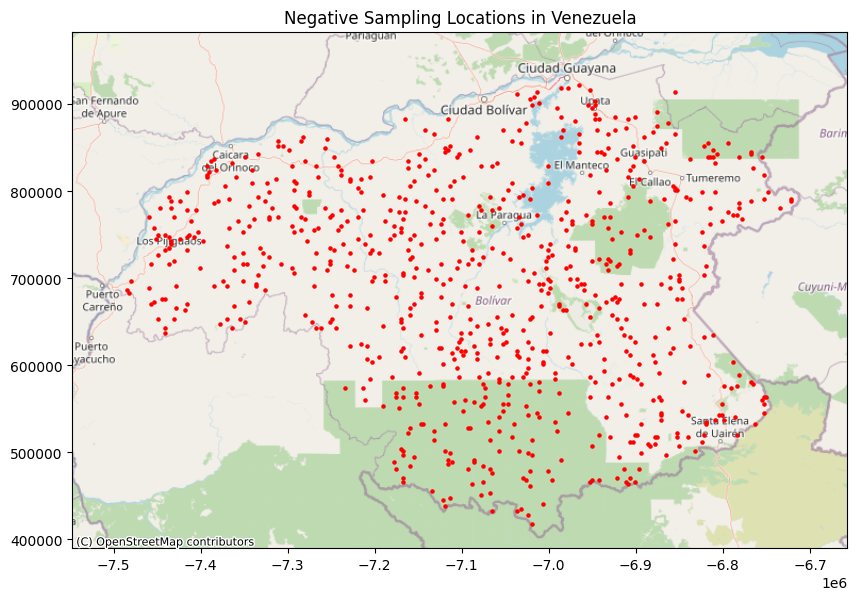

In [ ]:
# Negative sampling locations
ax = negative_points.to_crs(epsg=3857).plot(marker='o', color='red', figsize=(10, 10), markersize=5)
# Set limits to Venezuela
ax.set_xlim([xmin, xmax])
ax.set_ylim([ymin, ymax])
cx.add_basemap(ax, source=cx.providers.OpenStreetMap.Mapnik)
plt.title("Negative Sampling Locations in Venezuela")
plt.show()

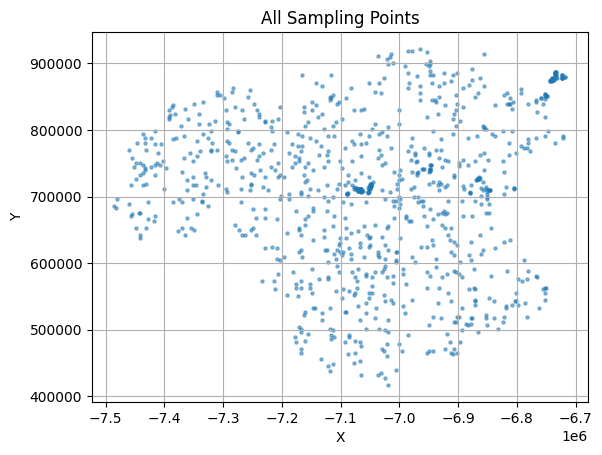

In [ ]:
import matplotlib.pyplot as plt

import pandas as pd

positive_points = positive_points.to_crs(epsg=3857)
negative_points = negative_points.to_crs(epsg=3857)

all_points = pd.concat([positive_points, negative_points], ignore_index=True)
all_coords = np.array([[geom.x, geom.y] for geom in all_points.geometry])

plt.scatter(all_coords[:, 0], all_coords[:, 1], s=5, alpha=0.5)
plt.title("All Sampling Points")
plt.xlabel("X")
plt.ylabel("Y")
plt.grid(True)
plt.show()

In [ ]:
import numpy as np
from sklearn.cluster import DBSCAN
import random

def spatial_split(positive_gdf, negative_gdf, eps=3000, min_samples=2):
    # Extract coordinates from geometry column
    pos_coords = np.array([[geom.x, geom.y] for geom in positive_gdf.geometry])
    neg_coords = np.array([[geom.x, geom.y] for geom in negative_gdf.geometry])

    all_coords = np.vstack([pos_coords, neg_coords])
    cluster_labels = DBSCAN(eps=eps, min_samples=min_samples).fit_predict(all_coords)

    unique_clusters = np.unique(cluster_labels)
    random.seed(7)
    random.shuffle(unique_clusters)

    n = len(unique_clusters)
    n_train = int(n * 0.7)
    n_val = int(n * 0.15)

    train_clusters = set(unique_clusters[:n_train])
    val_clusters = set(unique_clusters[n_train:n_train + n_val])
    test_clusters = set(unique_clusters[n_train + n_val:])

    train_indices = [i for i, c in enumerate(cluster_labels) if c in train_clusters]
    val_indices = [i for i, c in enumerate(cluster_labels) if c in val_clusters]
    test_indices = [i for i, c in enumerate(cluster_labels) if c in test_clusters]

    return train_indices, val_indices, test_indices

train_idx_base, val_idx_base, test_idx = spatial_split(positive_points, negative_points)



In [ ]:
len(train_idx_base) == 0
len(val_idx_base) == 0

False

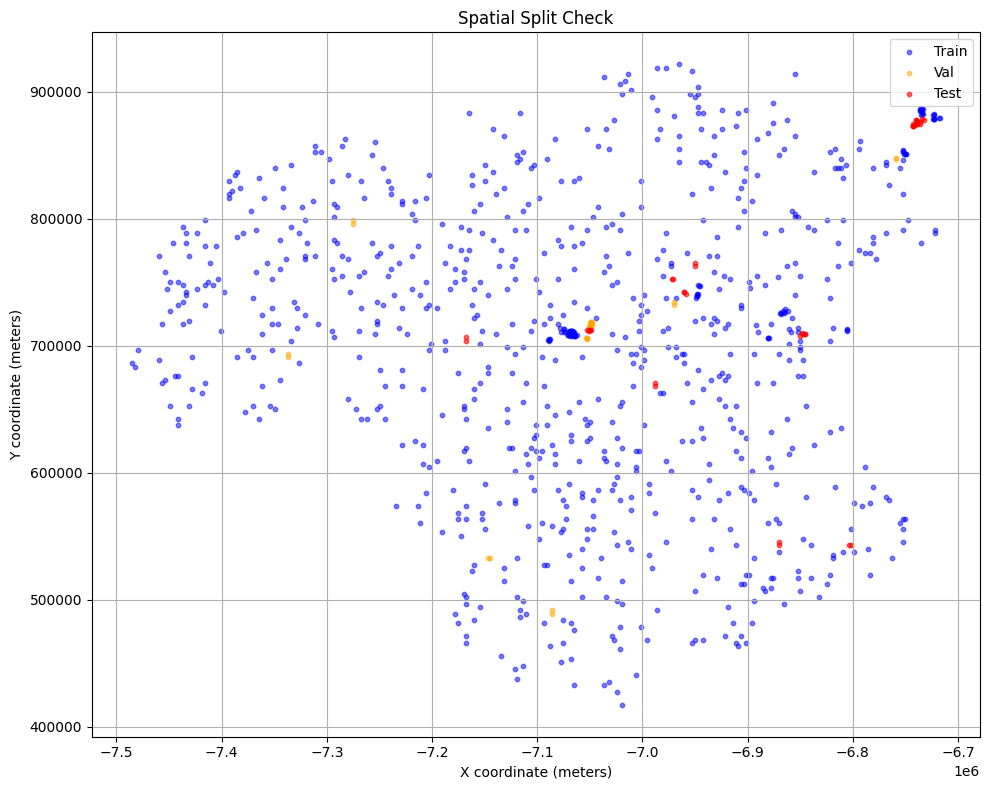

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

import matplotlib.pyplot as plt
import numpy as np

def plot_spatial_split(pos_gdf, neg_gdf, train_idx, val_idx, test_idx):
    # Extract coordinates
    pos_coords = np.array([[geom.x, geom.y] for geom in pos_gdf.geometry])
    neg_coords = np.array([[geom.x, geom.y] for geom in neg_gdf.geometry])
    all_coords = np.vstack([pos_coords, neg_coords])

    # Split into groups
    train_coords = all_coords[train_idx]
    val_coords = all_coords[val_idx]
    test_coords = all_coords[test_idx]

    plt.figure(figsize=(10, 8))

    if len(train_coords) > 0:
        plt.scatter(train_coords[:, 0], train_coords[:, 1], color='blue', s=10, alpha=0.5, label='Train')
    if len(val_coords) > 0:
        plt.scatter(val_coords[:, 0], val_coords[:, 1], color='orange', s=10, alpha=0.5, label='Val')
    if len(test_coords) > 0:
        plt.scatter(test_coords[:, 0], test_coords[:, 1], color='red', s=10, alpha=0.6, label='Test')

    plt.legend()
    plt.title("Spatial Split Check")
    plt.xlabel("X coordinate (meters)")
    plt.ylabel("Y coordinate (meters)")
    plt.grid(True)
    plt.tight_layout()
    plt.show()



plot_spatial_split(positive_points, negative_points, train_idx_base, val_idx_base, test_idx)

# Creating the Patches

In [5]:
# load a file from sampling_locations
data_dir = '../data/sampling_locations/'
start_dates = ['2021-01-01']
end_dates = ['2021-12-31']
clear_threshold = 0.75  # minimum clear pixels for a tile to be included in the dataset

patch_size = 256

data_files = ['random_negatives_bolivar']

data_file_labels = [0]

In [6]:
# # create the training data
# all_tiles = []
# all_data = []
# for sampling_file, label_class in zip(data_files, data_file_labels):
#     print(f'Creating training data for {sampling_file} with class {label_class}')
#     for start_date, end_date in zip(start_dates, end_dates):
#         training_data = get_training_data.TrainingData(
#             sampling_file,
#             label_class,
#             patch_size,
#             start_date, 
#             end_date, 
#             clear_threshold
#             )
        
#         tiles, data = training_data.get_patches()
#         all_tiles.append(tiles)
#         all_data.append(data)

In [7]:
from datetime import date
import os
import pickle
import sys

import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm

parent_dir = os.path.split(os.getcwd())[0]
if parent_dir not in sys.path:
    sys.path.insert(0, parent_dir)

from scripts import dl_utils
from scripts import viz_tools
resolution = 256

data_file_names = [
    'random_negatives_bolivar',
    'v2.1_bolivar_positives_cleaned'
              ]

start_dates = ['2021-01-01']
end_dates = ['2021-12-31']
dates = [f'{sd}_{ed}' for sd,ed in zip(start_dates, end_dates)]
data_files = [f'{fn}_{sd}_{ed}_patch_arrays.pkl' for fn in data_file_names for sd, ed in zip(start_dates, end_dates)]
label_files = [f.split('s.pkl')[0] + '_labels.pkl' for f in data_files]

patches = []
labels = []

data_dir = os.path.join('..', 'data', 'training_data', f"{resolution}_px")

for data, label in tqdm(zip(data_files, label_files), total=len(data_files)):
    with open(os.path.join(data_dir, data), 'rb') as f:
        data = pickle.load(f)
        for elem in data:
            #patch = dl_utils.pad_patch(elem, resolution)
            patches.append(elem)
    with open(os.path.join(data_dir, label), 'rb') as f:
        label = pickle.load(f)
        labels = np.concatenate((labels, label))

patches = np.array(patches)
positive_patches = patches[labels == 1]
negative_patches = patches[labels == 0]

print(len(patches), "samples loaded")
print(sum(labels == 1), "positive samples")
print(sum(labels == 0), "negative samples")

100%|██████████| 2/2 [00:04<00:00,  2.17s/it]


936 samples loaded
156 positive samples
780 negative samples


# Create OSM Patches

In [8]:
import pandas as pd
def create_osm_patches_from_tiles(tile_path, osm_path):
    """
    Loads precomputed tile objects and clips OSM data to each tile.

    Args:
        tile_path (str): Path to .pkl file containing saved tile objects.
        osm_path (str): Path to the contextual OSM features GeoJSON.

    Returns:
        tuple: (tile_objects, osm_patches_gdf)
    """
    import pickle

    # Load tile objects
    with open(tile_path, "rb") as f:
        tile_objects = pickle.load(f)

    # Load and reproject OSM data
    osm_gdf = gpd.read_file(osm_path)
    osm_gdf = osm_gdf.to_crs("EPSG:4326")

    # Clip to each tile
    osm_patches = []
    for idx, tile in enumerate(tile_objects):
        patch_gdf = osm_gdf.clip(tile.geometry)
        patch_gdf["patch_id"] = idx
        osm_patches.append(patch_gdf)

    osm_patches_gdf = gpd.GeoDataFrame(pd.concat(osm_patches, ignore_index=True), crs="EPSG:4326")
    
    return tile_objects, osm_patches_gdf

# For positive samples
tiles_p, osm_patches_p_gdf = create_osm_patches_from_tiles(
    tile_path="../data/tiles/v2.1_bolivar_positives_cleaned_2021-01-01_2021-12-31_tiles.pkl",
    osm_path="../data/contextual/osm_bolivar_features.geojson"
)

# For negative samples
tiles_n, osm_patches_n_gdf = create_osm_patches_from_tiles(
    tile_path="../data/tiles/random_negatives_bolivar_2021-01-01_2021-12-31_tiles.pkl",
    osm_path="../data/contextual/osm_bolivar_features.geojson"
)

/Users/selmadissing/miniforge3/envs/mining-detector/lib/python3.11/site-packages/pyogrio/raw.py:198: RuntimeWarning: Several features with id = 313500437 have been found. Altering it to be unique. This warning will not be emitted anymore for this layer
  return ogr_read(
/Users/selmadissing/miniforge3/envs/mining-detector/lib/python3.11/site-packages/pyogrio/raw.py:198: RuntimeWarning: Several features with id = 313500437 have been found. Altering it to be unique. This warning will not be emitted anymore for this layer
  return ogr_read(


In [9]:
# assert len(tiles_p) == len(positive_patches), "Mismatch in positive tiles and patches"
# assert len(tiles_n) == len(negative_patches), "Mismatch in negative tiles and patches"

# Plot grid of random patches

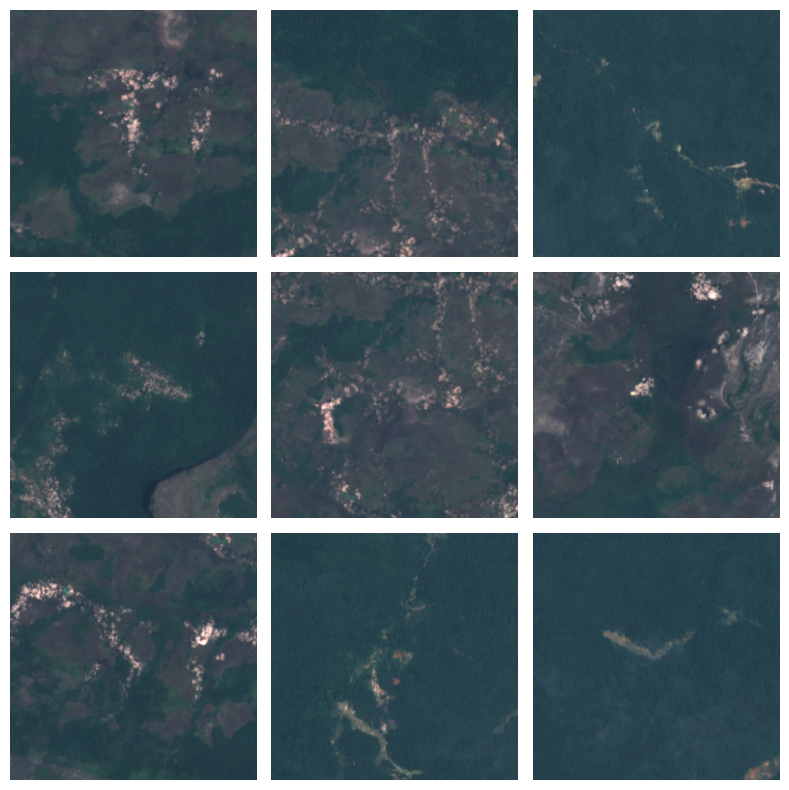

In [10]:
import matplotlib.pyplot as plt
import numpy as np

def plot_negative_grid(patches, labels, save_path=None):
    """
    Plot a 3x3 grid of negative (non-mining) RGB patches using Sentinel-2 bands 4-3-2.

    Args:
        patches (np.ndarray): Array of image patches (H, W, Bands).
        labels (np.ndarray): Corresponding class labels (0 for non-mining).
        save_path (str): Optional path to save the output PNG.
    """
    negative_samples = patches[labels == 1]
    np.random.shuffle(negative_samples)
    negative_samples = negative_samples[:9]

    # Create subplot grid
    fig, axes = plt.subplots(3, 3, figsize=(8, 8))
    
    for i, ax in enumerate(axes.flat):
        patch = negative_samples[i]
        rgb = np.clip(patch[:, :, (3, 2, 1)] / 3000, 0, 1)  # Normalize and clip
        ax.imshow(rgb)
        ax.axis('off')

    #fig.suptitle('Random Non-Mining (Negative) Patches', fontsize=16)
    plt.tight_layout()

    if save_path:
        fig.savefig(save_path, dpi=300, bbox_inches='tight', pad_inches=0)
    
    plt.show()

plot_negative_grid(patches, labels, save_path='negative_grid.png')

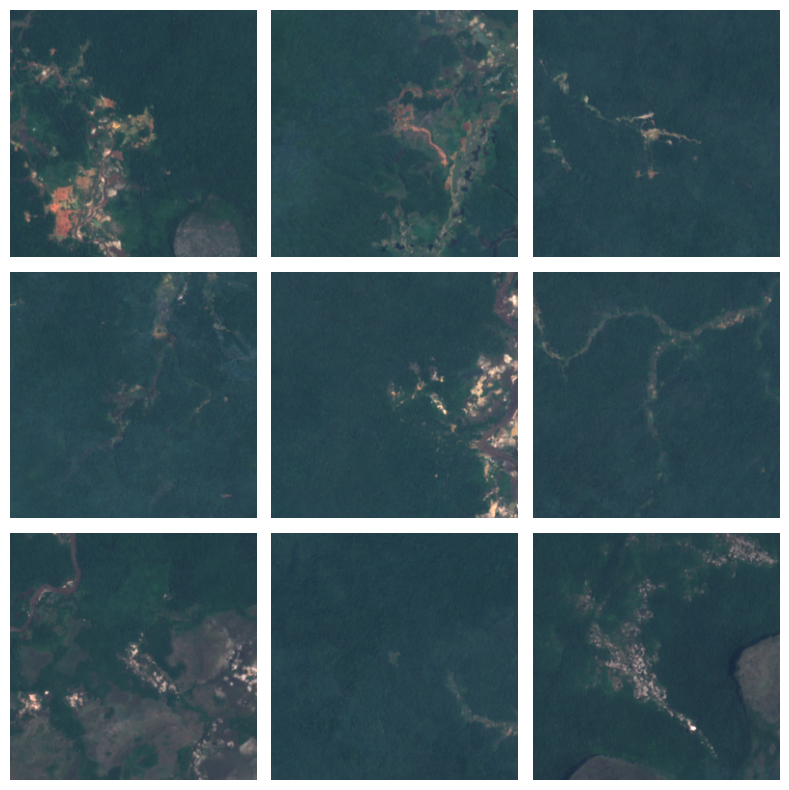

In [11]:
def plot_positive_grid(patches, labels, save_path=None):
    """
    Plot a 3x3 grid of negative (non-mining) RGB patches using Sentinel-2 bands 4-3-2.

    Args:
        patches (np.ndarray): Array of image patches (H, W, Bands).
        labels (np.ndarray): Corresponding class labels (0 for non-mining).
        save_path (str): Optional path to save the output PNG.
    """
    # Select first 9 negative patches
    negative_samples = patches[labels == 1]
    np.random.shuffle(negative_samples)
    negative_samples = negative_samples[:9]

    # Create subplot grid
    fig, axes = plt.subplots(3, 3, figsize=(8, 8))
    
    for i, ax in enumerate(axes.flat):
        patch = negative_samples[i]
        rgb = np.clip(patch[:, :, (3, 2, 1)] / 3000, 0, 1)  # Normalize and clip
        ax.imshow(rgb)
        ax.axis('off')

    #fig.suptitle('Random Mining (Positive) Patches', fontsize=16)
    plt.tight_layout()

    if save_path:
        fig.savefig(save_path, dpi=300, bbox_inches='tight', pad_inches=0)
    
    plt.show()

plot_positive_grid(patches, labels, save_path='positive_grid.png')

# Visual Overlay

In [42]:
import seaborn as sns
import matplotlib.colors as mcolors
feature_tags = ["waterway", "highway", "landuse", "building", "aeroway"]
palette = sns.color_palette("tab10", n_colors=len(feature_tags))
color_map = dict(zip(feature_tags, [mcolors.to_hex(c) for c in palette]))

In [43]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np

def show_s2_with_osm_overlay(image, tile, osm_patch_gdf, bands=(3, 2, 1), color_map=None, ax=None):
    """
    Plots a Sentinel-2 image patch with overlaid OSM features clipped to the tile geometry.

    Args:
        image (np.array): 3D numpy array (H x W x bands)
        tile (Tile): Tile object with .geometry and .bounds in EPSG:4326
        osm_patch_gdf (GeoDataFrame): OSM features clipped to this tile (can be empty)
        patch_id (int or None): Optional patch ID for labeling
        bands (tuple): Which Sentinel-2 bands to use as RGB
        color_map (dict): Mapping of feature tags to colors
        ax (matplotlib axis): Optional axis to draw on
    """
    # Check whether to plot on a provided axis
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 8))

    # Normalize the Sentinel-2 image and plot it using geospatial bounds
    rgb = np.clip(image[:, :, bands] / 3000, 0, 1)  # Normalize pixel values for display
    minx, miny, maxx, maxy = tile.geometry.bounds
    ax.imshow(rgb, extent=[minx, maxx, miny, maxy], origin="upper")

    # If there are OSM features and a color map provided, overlay features
    if not osm_patch_gdf.empty and color_map:
        legend_patches = []  # Store legend entries for OSM feature types
        for feature in color_map.keys():
            if feature in osm_patch_gdf.columns:
                subset = osm_patch_gdf[osm_patch_gdf[feature].notnull()]
                if not subset.empty:
                    color = color_map[feature]
                    geom_type = subset.geometry.iloc[0].geom_type
                    # Plot line or polygon features
                    if geom_type in ["LineString", "MultiLineString", "Polygon", "MultiPolygon"]:
                        subset.plot(ax=ax, color=color, linewidth=2)
                    # Plot point features
                    else:
                        subset.plot(ax=ax, color=color, markersize=10)
                    # Add to legend
                    legend_patches.append(mpatches.Patch(color=color, label=feature))

        # Display legend if any OSM features were plotted and working on an internal plot
        if legend_patches:
            ax.legend(handles=legend_patches, title="OSM Features", fontsize="small")

    # Hide axis ticks
    ax.axis("off")

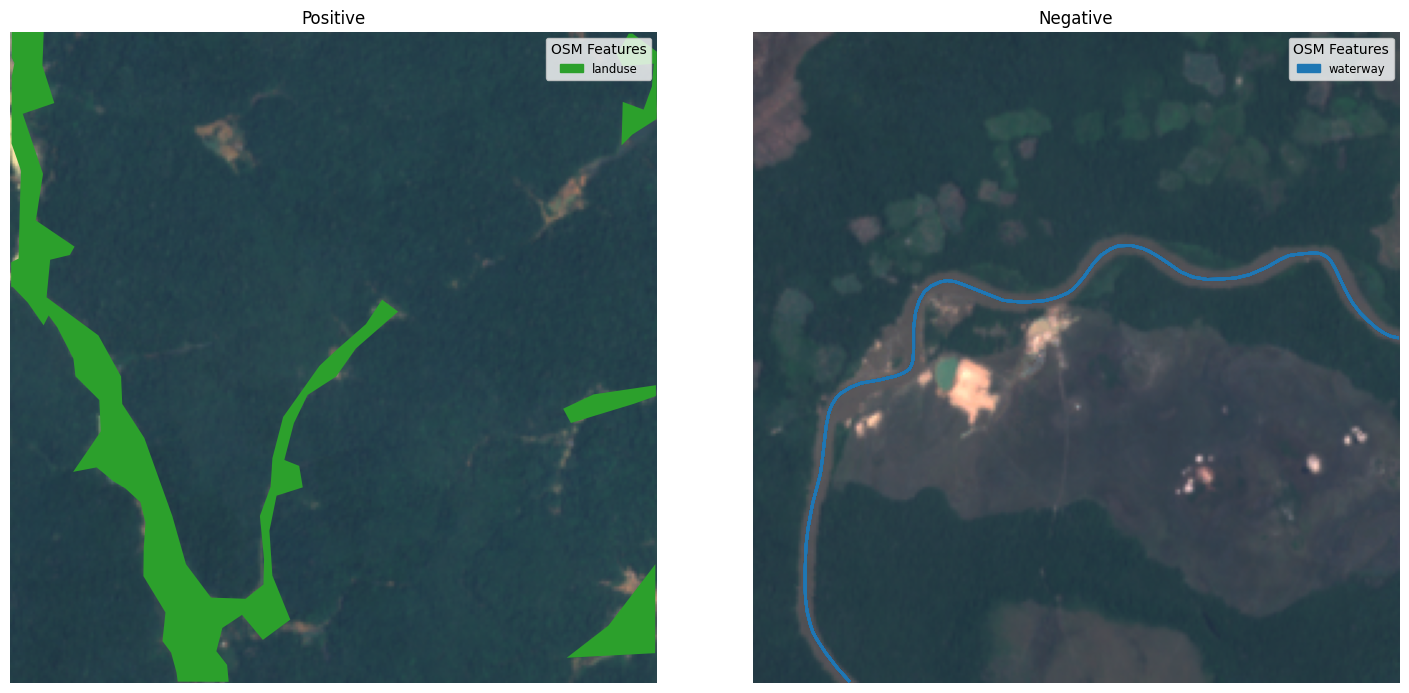

In [49]:
import random
import matplotlib.pyplot as plt

# Sample 1 unique positive and 1 unique negative index
sample_pos = random.sample(range(len(tiles_p)), 1)
sample_neg = random.sample(range(len(tiles_n)), 1)

# Create a 1x2 grid for plotting
fig, axes = plt.subplots(1, 2, figsize=(15, 7))

# Plot positive patch
tile = tiles_p[sample_pos[0]]
s2_patch = positive_patches[sample_pos[0]]
osm_patch = osm_patches_p_gdf[osm_patches_p_gdf.patch_id == sample_pos[0]]
show_s2_with_osm_overlay(s2_patch, tile, osm_patch_gdf=osm_patch, color_map=color_map, ax=axes[0])
axes[0].set_title(f"Positive")

# Plot negative patch
tile = tiles_n[sample_neg[0]]
s2_patch = negative_patches[sample_neg[0]]
osm_patch = osm_patches_n_gdf[osm_patches_n_gdf.patch_id == sample_neg[0]]
show_s2_with_osm_overlay(s2_patch, tile, osm_patch_gdf=osm_patch, color_map=color_map, ax=axes[1])
axes[1].set_title(f"Negative")

plt.tight_layout()
plt.show()


In [15]:
# Count positive patches with OSM data
unique_p_patches_with_osm = osm_patches_p_gdf[osm_patches_p_gdf.geometry.notnull()]["patch_id"].nunique()
print(f"Number of positive patches with OSM data: {unique_p_patches_with_osm} out of {len(tiles_p)} total patches")
# print percentage of patches with OSM data
print(f"Percentage of positive patches with OSM data: {unique_p_patches_with_osm / len(tiles_p) * 100:.2f}%")

# Count negative patches with OSM data
unique_n_patches_with_osm = osm_patches_n_gdf[osm_patches_n_gdf.geometry.notnull()]["patch_id"].nunique()
print(f"Number of negative patches with OSM data: {unique_n_patches_with_osm} out of {len(tiles_n)} total patches")
# print percentage of patches with OSM data
print(f"Percentage of negative patches with OSM data: {unique_n_patches_with_osm / len(tiles_n) * 100:.2f}%")


Number of positive patches with OSM data: 95 out of 156 total patches
Percentage of positive patches with OSM data: 60.90%
Number of negative patches with OSM data: 251 out of 780 total patches
Percentage of negative patches with OSM data: 32.18%


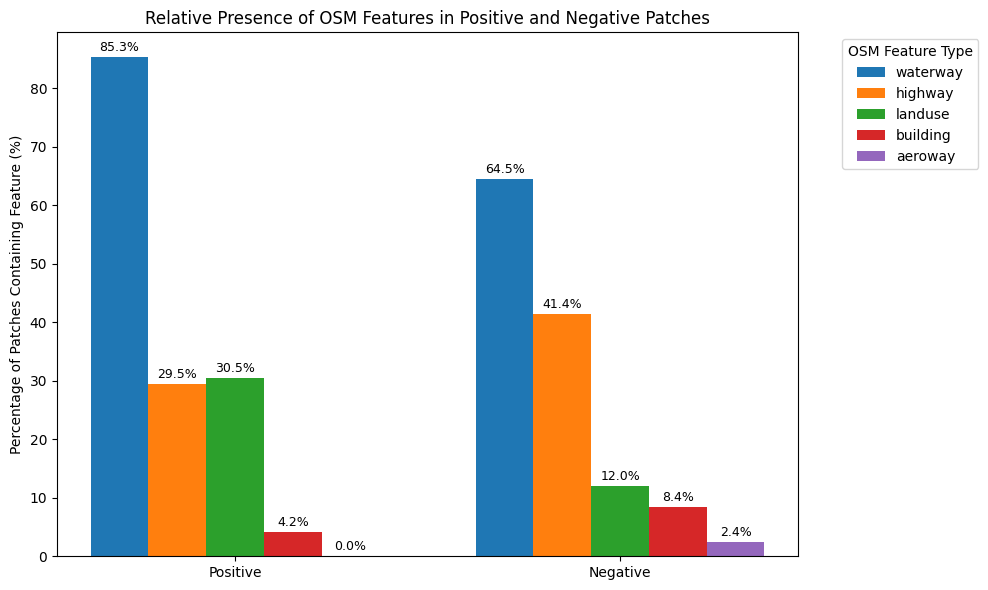

In [25]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import matplotlib.colors as mcolors

# Feature tags and color map
feature_tags = ["waterway", "highway", "landuse", "building", "aeroway"]
palette = sns.color_palette("tab10", n_colors=len(feature_tags))
color_map = dict(zip(feature_tags, [mcolors.to_hex(c) for c in palette]))

# Count the number of unique patches with each feature (not number of features)
def count_feature_presence(gdf, feature):
    return gdf[gdf[feature].notnull()]['patch_id'].nunique()

# Total number of patches per class
n_positive = len(osm_patches_p_gdf['patch_id'].unique())
n_negative = len(osm_patches_n_gdf['patch_id'].unique())

# Compute relative counts (as percentages)
positive_counts = {feat: count_feature_presence(osm_patches_p_gdf, feat) / n_positive * 100 for feat in feature_tags}
negative_counts = {feat: count_feature_presence(osm_patches_n_gdf, feat) / n_negative * 100 for feat in feature_tags}

# Prepare data
data = []
for feat in feature_tags:
    data.append({'Patch Type': 'Positive', 'Feature': feat, 'Percent': positive_counts[feat]})
    data.append({'Patch Type': 'Negative', 'Feature': feat, 'Percent': negative_counts[feat]})
df = pd.DataFrame(data)

# Plot
fig, ax = plt.subplots(figsize=(10, 6))
patch_types = ['Positive', 'Negative']
bar_width = 0.15
x = list(range(len(patch_types)))

# Offset positions for each feature
for i, feat in enumerate(feature_tags):
    values = [df[(df['Patch Type'] == pt) & (df['Feature'] == feat)]['Percent'].values[0] for pt in patch_types]
    positions = [pos + (i - len(feature_tags)/2)*bar_width + bar_width/2 for pos in x]
    bars = ax.bar(positions, values, width=bar_width, color=color_map[feat], label=feat)
    
    # Annotate bars
    for pos, val in zip(positions, values):
        ax.text(pos, val + 0.5, f'{val:.1f}%', ha='center', va='bottom', fontsize=9)

# Format
ax.set_xticks(x)
ax.set_xticklabels(patch_types)
ax.set_ylabel('Percentage of Patches Containing Feature (%)')
ax.set_title('Relative Presence of OSM Features in Positive and Negative Patches')
ax.legend(title='OSM Feature Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Create OSM masks per patch

In [16]:
import numpy as np
import rasterio
import rasterio.features
from rasterio.transform import from_bounds

def create_osm_feature_masks(tile, osm_patch_gdf, feature_tags, output_shape):
    """
    Creates a stack of binary masks for the given OSM features.

    Args:
        tile (Tile): Tile object containing .geometry and .bounds.
        osm_patch_gdf (GeoDataFrame): OSM features clipped to the tile.
        feature_tags (list): List of feature column names to generate masks for.
        output_shape (tuple): (height, width) of the output masks.

    Returns:
        np.ndarray: (height, width, number of features) mask array.
    """
    masks = np.zeros((*output_shape, len(feature_tags)), dtype=np.uint8)

    # Manually create an affine transform from tile bounds
    minx, miny, maxx, maxy = tile.geometry.bounds
    transform = from_bounds(minx, miny, maxx, maxy, output_shape[1], output_shape[0])

    if not osm_patch_gdf.empty:
        for idx, feature in enumerate(feature_tags):
            if feature in osm_patch_gdf.columns:
                subset = osm_patch_gdf[osm_patch_gdf[feature].notnull()]
                if not subset.empty:
                    try:
                        mask = rasterio.features.rasterize(
                            ((geom, 1) for geom in subset.geometry),
                            out_shape=output_shape,
                            transform=transform,  # 🛠 use the manually created transform
                            fill=0,
                            dtype=np.uint8
                        )
                        masks[:, :, idx] = mask
                    except Exception as e:
                        print(f"⚠️ Rasterization error for feature {feature}: {e}")

    return masks

# Process Positive and Negative Patches + Create Combined Inputs

In [37]:
import os
import pickle

# --- Define feature tags ---
feature_tags = ["aeroway"]

# ["highway", "landuse", "building", "aeroway", "waterway"]

# --- Storage lists ---
positive_inputs = []
positive_labels = []

negative_inputs = []
negative_labels = []

# --- Process positive patches ---
for i, tile in enumerate(tiles_p):
    s2_patch = positive_patches[i]  # Sentinel-2 image patch
    osm_patch = osm_patches_p_gdf[osm_patches_p_gdf.patch_id == i]  # OSM features for this patch

    # Create OSM masks
    osm_masks = create_osm_feature_masks(tile, osm_patch, feature_tags, output_shape=s2_patch.shape[:2])

    # Stack Sentinel-2 bands and OSM masks together
    combined = np.concatenate([s2_patch, osm_masks], axis=-1)

    positive_inputs.append(combined)
    positive_labels.append(1)

# --- Process negative patches ---
for i, tile in enumerate(tiles_n):
    s2_patch = negative_patches[i]
    osm_patch = osm_patches_n_gdf[osm_patches_n_gdf.patch_id == i]

    osm_masks = create_osm_feature_masks(tile, osm_patch, feature_tags, output_shape=s2_patch.shape[:2])
    combined = np.concatenate([s2_patch, osm_masks], axis=-1)

    negative_inputs.append(combined)
    negative_labels.append(0)

# --- Convert to arrays ---
positive_inputs = np.array(positive_inputs)
positive_labels = np.array(positive_labels)

negative_inputs = np.array(negative_inputs)
negative_labels = np.array(negative_labels)

In [38]:
# print shapes of sentinel-2 patches before and after concatenation
print(f"Sentinel-2 patches shape before concatenation: {negative_patches.shape}")
print(f"Sentinel-2 patches shape after concatenation: {negative_inputs.shape}")

# print shapes of OSM masks
print(f"OSM masks shape: {osm_masks.shape}")

# print shapes of positive and negative inputs
print(f"Positive inputs shape: {positive_inputs.shape}")
print(f"Negative inputs shape: {negative_inputs.shape}")

# print shapes of positive and negative labels
print(f"Positive labels shape: {positive_labels.shape}")
print(f"Negative labels shape: {negative_labels.shape}")

Sentinel-2 patches shape before concatenation: (780, 256, 256, 12)
Sentinel-2 patches shape after concatenation: (780, 256, 256, 13)
OSM masks shape: (256, 256, 1)
Positive inputs shape: (156, 256, 256, 13)
Negative inputs shape: (780, 256, 256, 13)
Positive labels shape: (156,)
Negative labels shape: (780,)


In [39]:
import matplotlib.pyplot as plt

def visualize_osm_channels(patch, feature_tags, figsize=(15, 5)):
    """
    Visualizes each OSM feature channel separately.
    
    Args:
        patch (np.ndarray): One input patch (H, W, 17) — Sentinel-2 + OSM stacked.
        feature_tags (list): List of OSM feature names (order must match stacking order).
        figsize (tuple): Size of the figure.
    """
    # Assuming Sentinel-2 bands come first, OSM masks are the last 5 channels
    osm_channels = patch[:, :, -len(feature_tags):]  # last 5 channels
    
    fig, axes = plt.subplots(1, len(feature_tags), figsize=figsize)
    
    for idx, (ax, feature_name) in enumerate(zip(axes, feature_tags)):
        ax.imshow(osm_channels[:, :, idx], cmap='gray')
        ax.set_title(feature_name, fontsize=10)
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()

# --- Usage example ---
# Pick a random patch
import random
idx = random.randint(0, len(positive_inputs) - 1)
sample_patch = positive_inputs[idx]

# Define feature tags (same order as used during stacking)
# feature_tags = ["waterway", "highway", "landuse", "building", "aeroway"]

# Visualize
# visualize_osm_channels(sample_patch, feature_tags)

In [40]:
import matplotlib.pyplot as plt
import numpy as np

def overlay_osm_on_rgb(patch, feature_tags, bands=(3, 2, 1), alpha=1.0, figsize=(8, 8)):
    """
    Overlays OSM masks onto Sentinel-2 RGB patch.
    
    Args:
        patch (np.ndarray): One input patch (H, W, Sentinel+OSM channels).
        feature_tags (list): List of OSM feature names.
        bands (tuple): Indices for Sentinel-2 RGB bands (default (3,2,1)).
        alpha (float): Transparency for the OSM overlay.
        figsize (tuple): Figure size.
    """
    num_sentinel_bands = patch.shape[-1] - len(feature_tags)
    
    # Extract Sentinel-2 RGB image
    rgb = patch[:, :, [bands[0], bands[1], bands[2]]]
    rgb = np.clip(rgb / 3000, 0, 1)  # Normalize for display if needed
    
    # Extract OSM channels
    osm_channels = patch[:, :, -len(feature_tags):]
    
    fig, ax = plt.subplots(figsize=figsize)
    ax.imshow(rgb)
    
    # Overlay each OSM mask in different color
    colors = ['cyan', 'orange', 'lime', 'red', 'purple']
    
    for idx, feature_name in enumerate(feature_tags):
        mask = osm_channels[:, :, idx]
        if np.any(mask):  # Only plot if the mask is not empty
            ax.imshow(np.ma.masked_where(mask == 0, mask), 
                      cmap=plt.cm.get_cmap('coolwarm'), 
                      alpha=alpha)
    
    ax.set_title("Sentinel-2 Patch with OSM Overlay")
    ax.axis('off')
    plt.tight_layout()
    plt.show()

# --- Usage example ---
# Pick a random patch
import random
idx = random.randint(0, len(positive_inputs) - 1)
sample_patch = positive_inputs[idx]

# Define feature tags
# feature_tags = ["waterway", "highway", "landuse", "building", "aeroway"]

# Visualize overlay
# overlay_osm_on_rgb(sample_patch, feature_tags)

# Save the combined inputs

In [41]:
# --- Define save settings ---
resolution = 256
file_prefix_neg = 'ablation_aeroway_negatives'
file_prefix_pos = 'ablation_aeroway_positives'
date_range = '2021-01-01_2021-12-31'

save_dir = os.path.join('..', 'data', 'training_data', f'{resolution}_px')
os.makedirs(save_dir, exist_ok=True)

# --- Save positive samples ---
with open(os.path.join(save_dir, f'{file_prefix_pos}_{date_range}_patch_arrays.pkl'), 'wb') as f:
    pickle.dump(positive_inputs, f)
with open(os.path.join(save_dir, f'{file_prefix_pos}_{date_range}_patch_array_labels.pkl'), 'wb') as f:
    pickle.dump(positive_labels, f)

# --- Save negative samples ---
with open(os.path.join(save_dir, f'{file_prefix_neg}_{date_range}_patch_arrays.pkl'), 'wb') as f:
    pickle.dump(negative_inputs, f)
with open(os.path.join(save_dir, f'{file_prefix_neg}_{date_range}_patch_array_labels.pkl'), 'wb') as f:
    pickle.dump(negative_labels, f)

# --- Summary ---
print(f"✅ Saved {len(positive_inputs)} positive samples with shape {positive_inputs.shape[1:]}.")
print(f"✅ Saved {len(negative_inputs)} negative samples with shape {negative_inputs.shape[1:]}.")
print(f"📦 Directory: {save_dir}")


✅ Saved 156 positive samples with shape (256, 256, 13).
✅ Saved 780 negative samples with shape (256, 256, 13).
📦 Directory: ../data/training_data/256_px
